In [170]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
import math
%matplotlib inline 



In [11]:
img = np.loadtxt("src.txt", dtype = np.uint8)
img = img.reshape((128,128))

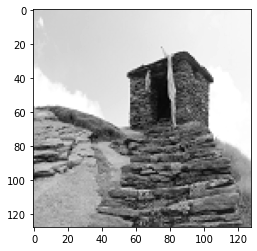

In [13]:
plt.imshow(img, cmap='gray')
plt.show()

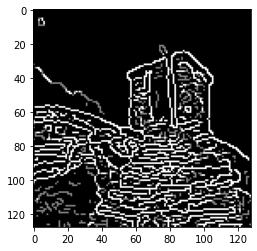

In [15]:
edge = np.loadtxt("dst.txt", dtype = np.uint8)
edge = edge.reshape((128,128))
plt.imshow(edge, cmap='gray')
plt.show()

In [203]:
def evaluate(src=img, dst=edge, show = True):
    diff = src - dst
    cnt = np.count_nonzero(diff)
    if show:
        if cnt > 64:
            print(f"worng image, different pixel: {cnt}")
        else:
            print(f'congratualation!, difference pixel :{cnt}')
    return cnt

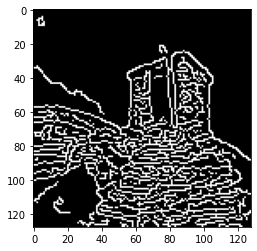

In [23]:
blurred = cv2.GaussianBlur(img, (3, 3), 1.5)
canny = cv2.Canny(blurred, 30, 80, True)
plt.imshow(canny, cmap='gray')
plt.show()

In [24]:
evaluate(canny, edge)

worng image, different pixel: 1223


In [171]:
kernel_sum = 4 + 4*math.exp(1/4.5) + math.exp(1/2.25)
gaussion = np.array([[1/kernel_sum, math.exp(1/4.5)/kernel_sum, 1/kernel_sum], [math.exp(1/4.5)/kernel_sum, math.exp(1/2.25)/kernel_sum, math.exp(1/4.5)/kernel_sum], [1/kernel_sum, math.exp(1/4.5)/kernel_sum, 1/kernel_sum]])
x_sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
y_sobel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

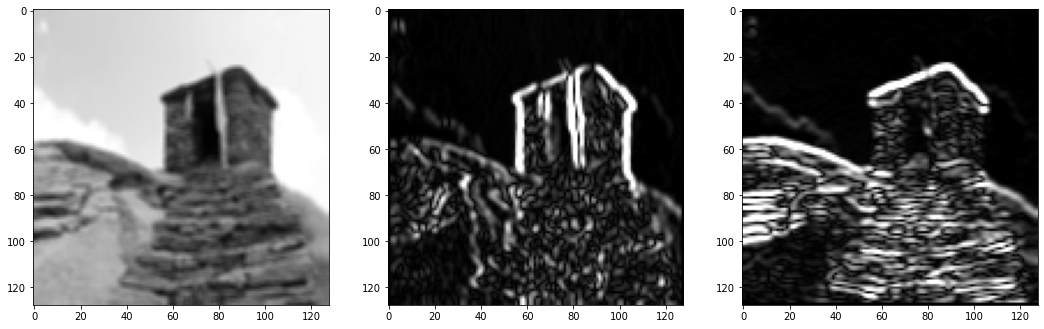

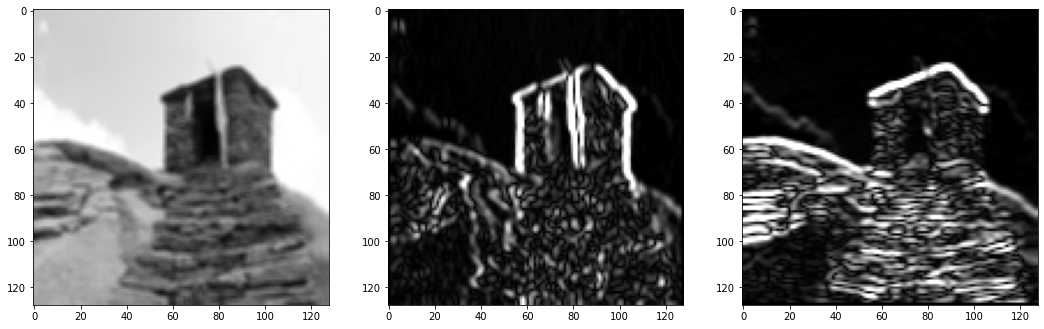

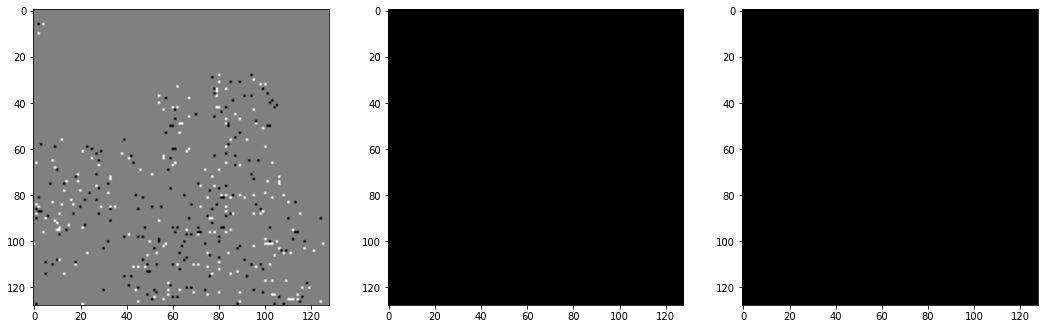

In [208]:
# my kernel
blurred = cv2.filter2D(img, ddepth=cv2.CV_16S, kernel=gaussion)
blur_x = cv2.filter2D(blurred, ddepth=cv2.CV_16S, kernel=x_sobel)
blur_y = cv2.filter2D(blurred, ddepth=cv2.CV_16S, kernel=y_sobel)
blur_x = cv2.convertScaleAbs(blur_x)
blur_y = cv2.convertScaleAbs(blur_y)
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(blurred, cmap='gray')
plt.subplot(132)
plt.imshow(blur_x, cmap='gray')
plt.subplot(133)
plt.imshow(blur_y, cmap='gray')
plt.show()
# build-in kernel
buildblurred = cv2.GaussianBlur(img, (3, 3), 1.5)
buildblur_x = cv2.Sobel(blurred, cv2.CV_16S, 1, 0)
buildblur_y = cv2.Sobel(blurred, cv2.CV_16S, 0, 1)
buildblur_x = cv2.convertScaleAbs(blur_x)
buildblur_y = cv2.convertScaleAbs(blur_y)
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(buildblurred, cmap='gray')
plt.subplot(132)
plt.imshow(buildblur_x, cmap='gray')
plt.subplot(133)
plt.imshow(buildblur_y, cmap='gray')
plt.show()
# show difference
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(blurred - buildblurred, cmap='gray')
plt.subplot(132)
plt.imshow(blur_x - buildblur_x, cmap='gray')
plt.subplot(133)
plt.imshow(blur_y - buildblur_y, cmap='gray')
plt.show()


In [184]:
blurred = cv2.filter2D(img, ddepth=cv2.CV_16S, kernel=gaussion)
blur_x = cv2.filter2D(blurred, ddepth=cv2.CV_16S, kernel=x_sobel)
blur_y = cv2.filter2D(blurred, ddepth=cv2.CV_16S, kernel=y_sobel)
blur_x = cv2.convertScaleAbs(blur_x)
blur_y = cv2.convertScaleAbs(blur_y)

In [209]:
G = np.hypot(blur_x, blur_y)
G = G / G.max() * 255
# G = G.astype('uint')
theta = np.arctan2(blur_y, blur_x)


In [224]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
#     angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
                #angle 0
                if (22.5 < angle[i,j] <= 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 45
                elif (67.5 < angle[i,j] <= 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 90
                elif (112.5 < angle[i,j] <= 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                #angle 135
                elif (-22.5 < angle[i,j] <= 22.5): #(0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
                
#                #angle 0
#                 if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
#                     q = img[i, j+1]
#                     r = img[i, j-1]
#                 #angle 45
#                 elif (22.5 <= angle[i,j] < 67.5):
#                     q = img[i+1, j-1]
#                     r = img[i-1, j+1]
#                 #angle 90
#                 elif (67.5 <= angle[i,j] < 112.5):
#                     q = img[i+1, j]
#                     r = img[i-1, j]
#                 #angle 135
#                 elif (112.5 <= angle[i,j] < 157.5):
#                     q = img[i-1, j-1]
#                     r = img[i+1, j+1]

#                 if (img[i,j] >= q) and (img[i,j] >= r):
#                     Z[i,j] = img[i,j]
#                 else:
#                     Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

def threshold(img, lowThreshold=30, highThreshold=80):
    
#     highThreshold = highThreshold;
#     lowThreshold = lowThreshold;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(127)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img <= lowThreshold)
    
    weak_i, weak_j = np.where((img < highThreshold) & (img > lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [231]:
# G, theta = sobel_filters(blurred)
sup = non_max_suppression(G, theta)
canny, w, s = threshold(sup, 21, 56)

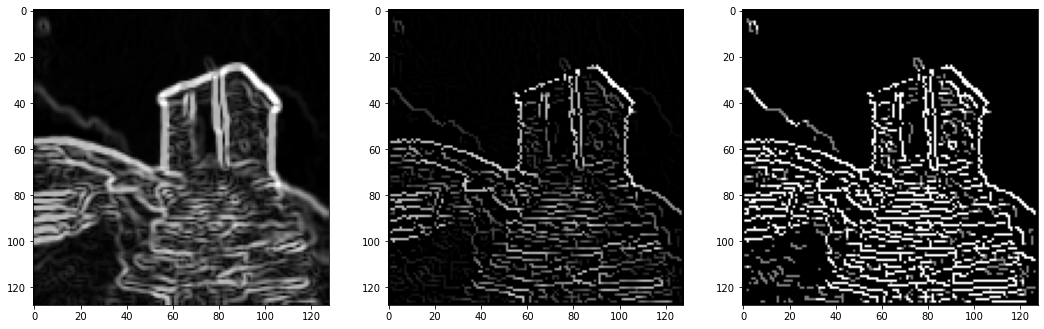

In [232]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(G.astype('uint'), cmap='gray')
plt.subplot(132)
plt.imshow(sup, cmap='gray')
plt.subplot(133)
plt.imshow(canny, cmap='gray')
plt.show()

In [237]:
evaluate(canny.astype('uint8'), edge)

worng image, different pixel: 743


743

In [236]:
canny.astype('uint8')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

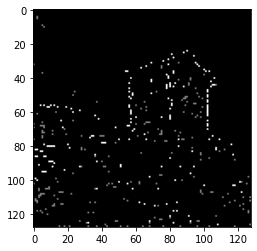

In [238]:
d_map = canny.astype('uint8') - edge
plt.imshow(d_map, cmap='gray')
plt.show()

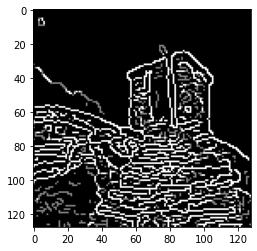

In [229]:
edge = np.loadtxt("dst.txt", dtype = np.uint8)
edge = edge.reshape((128,128))
plt.imshow(edge, cmap='gray')
plt.show()

In [230]:
min_val = 16384
lowth = 0
highth = 255
for i in range(2,255):
#     sup = non_max_suppression(G, theta)
    for j in range(i):
        canny, w, s = threshold(sup, j, i)
        val = evaluate(canny, edge, False)
        if (val < min_val):
            min_val = val
            lowth = j
            highth = i
print(f"low threshold: {lowth}, high threshold: {highth}")
canny, w, s = threshold(sup, lowth,highth)
val = evaluate(canny, edge)

low threshold: 21, high threshold: 56
